In [75]:
import numpy as np
import matplotlib.pyplot as plt
from npeb import GLMixture
import pandas as pd
import cvxpy as cvx

In [76]:
df = pd.read_csv('../data/exp_programs_test_reads_personalization_ui_202406.csv')

In [77]:
df.experimentation_program

0        personalization
1        personalization
2        personalization
3        personalization
4        personalization
              ...       
5370    ui_new_to_device
5371    ui_new_to_device
5372    ui_new_to_device
5373    ui_new_to_device
5374    ui_new_to_device
Name: experimentation_program, Length: 5375, dtype: object

In [78]:
program = "personalization"

cols = ["test_id",
        "test_name",
        "days_with_a_qualified_play__treatment_effect__mean_stderr",
        "days_with_a_qualified_play__treatment_effect__mean",
        'decided_utc_date']
xp = df.loc[(df.experimentation_program == program) & (df.cell != '1'), cols]

xp.days_with_a_qualified_play__treatment_effect__mean_stderr.astype(float)
xp.days_with_a_qualified_play__treatment_effect__mean.astype(float)
xp = xp.dropna()

# Ensure 'decided_utc_date' is in datetime format
xp['decided_utc_date'] = pd.to_datetime(xp['decided_utc_date'].astype(int).astype(str), format='%Y%m%d')

# Extract the year from 'decided_utc_date'
xp['year'] = xp['decided_utc_date'].dt.year
xp = xp.loc[xp.year >= 2020,:]

observed_effects = np.array(xp.days_with_a_qualified_play__treatment_effect__mean).reshape(-1,1)
standard_errors = np.array(xp.days_with_a_qualified_play__treatment_effect__mean_stderr).reshape(-1,1)

In [79]:
observed_effects

array([[-0.00360574],
       [ 0.00019545],
       [ 0.00360451],
       ...,
       [-0.00411253],
       [-0.00088511],
       [ 0.00045136]])

In [80]:
observed_effects.shape

(1780, 1)

## Parametric Normal Model

In [82]:
normal_eb_estimates, mu, tau = empirical_bayes_normal(observed_effects, standard_errors)

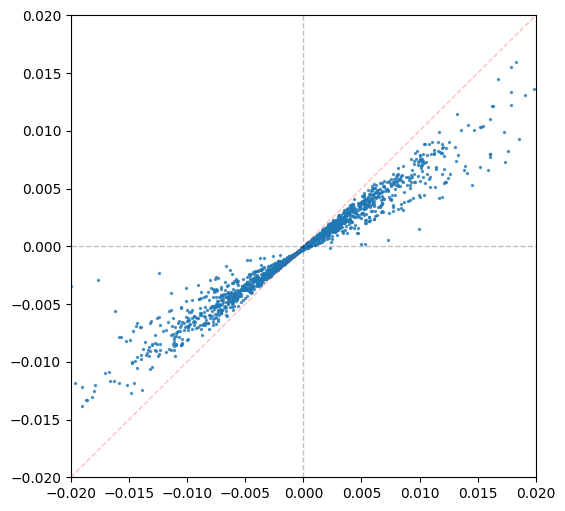

In [83]:
plt.figure(figsize = (6,6))
plt.scatter(observed_effects, normal_eb_estimates, s = 2, alpha = 0.7)

plt.xlim(-0.02,0.02)
plt.ylim(-0.02,0.02)

plt.plot(np.linspace(-0.02,0.02,100), np.linspace(-0.02,0.02,100),
          color = 'red', linestyle = 'dashed', linewidth = 1, alpha = 0.25)

plt.axhline(0, linewidth = 1, color = 'black', linestyle = 'dashed', alpha = 0.25)
plt.axvline(0, linewidth = 1, color = 'black', linestyle = 'dashed', alpha = 0.25)

## Nonparametric EB

In [86]:
m = GLMixture(prec_type='diagonal')
 
## Compute the NPMLE 
m.fit(X = observed_effects,
       prec = 1./standard_errors**2)

shrunk_estimates = m.posterior_mean(observed_effects, 1./standard_errors**2)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


Text(0.5, 0, 'Shrunken Estimates')

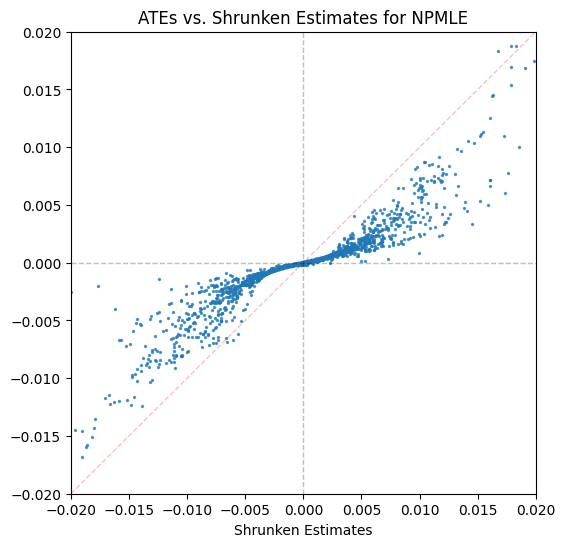

In [89]:

plt.figure(figsize = (6,6))
plt.scatter(observed_effects, shrunk_estimates, s = 2 , alpha = 0.7)

plt.xlim(-0.02,0.02)
plt.ylim(-0.02,0.02)
plt.plot(np.linspace(-0.02,0.02,100), np.linspace(-0.02,0.02,100),
          color = 'red', linestyle = 'dashed', linewidth = 1, alpha = 0.25)


plt.axhline(0, linewidth = 1, color = 'black', linestyle = 'dashed', alpha = 0.25)
plt.axvline(0, linewidth = 1, color = 'black', linestyle = 'dashed', alpha = 0.25)

plt.title("ATEs vs. Shrunken Estimates for NPMLE")
plt.xlabel("ATEs")
plt.xlabel("Shrunken Estimates")

In [92]:
import numpy as np

def summarize_array(arr):
    summary = {}
    summary['median'] = np.median(arr)
    summary['mean'] = np.mean(arr)
    summary['range'] = np.ptp(arr)  # ptp stands for "peak to peak"
    summary['std_dev'] = np.std(arr)
    summary['min'] = np.min(arr)
    summary['max'] = np.max(arr)
    
    return summary

summarize_array(weights)

{'median': np.float64(3.363994100016999e-12),
 'mean': np.float64(0.000566251415628539),
 'range': np.float64(0.6519751612704195),
 'std_dev': np.float64(0.01608541961374699),
 'min': np.float64(3.649314119429446e-15),
 'max': np.float64(0.6519751612704232)}

In [93]:
sorted_weights = np.sort(weights)
cumulative_weights = sorted_weights.cumsum()

idx = np.searchsorted(cumulative_weights, 0.0001) # remove bottom atoms which contribute 1% of total mass, for visualization purposes

cutoff = sorted_weights[idx]
print(cutoff)

0.0005624405813314884


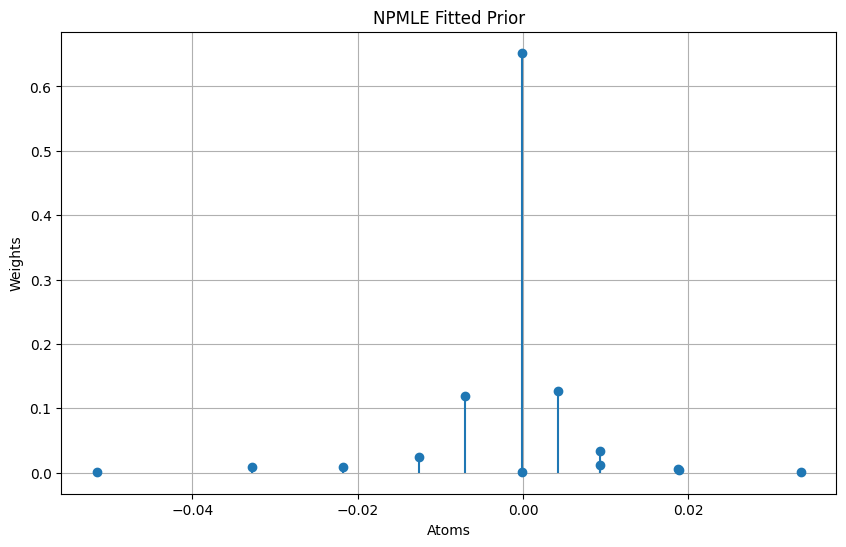

In [94]:
def plot_distribution(atoms, weights):
    # Normalize weights to make sure they sum up to 1
    weights = weights / np.sum(weights)
    
    plt.figure(figsize=(10, 6))
    plt.stem(atoms, weights, basefmt=" ")
    plt.xlabel('Atoms')
    plt.ylabel('Weights')
    plt.title('NPMLE Fitted Prior')
    plt.grid(True)
    plt.show()

mask = (weights > cutoff)
plot_distribution(atoms[mask], weights[mask])

In [50]:
npeb_prior = (atoms[mask], weights[mask])

In [51]:
ns = np.linspace(1_000,250_000_000, 500)
prod_fcn_vals = np.zeros_like(ns)
sigma = 9.

for i in range(len(ns)):
    prod_fcn_vals[i] = evaluate_production_function(ns[i], npeb_prior, sigma, 1_000_000)


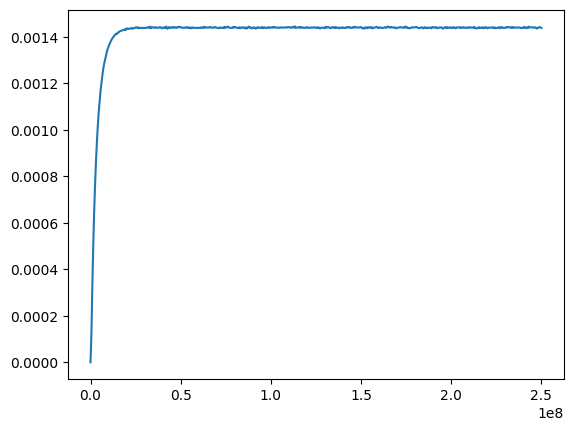

In [52]:
plt.plot(ns, prod_fcn_vals)